In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
from sklearn.preprocessing import OrdinalEncoder
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer, CountEncoder

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('../preprocessing/preprocess_df.pkl')

In [3]:
# 走行距離 / 製造年
df["odometer_per_year"] = df["odometer"] / (2023 - df["year"])

In [11]:
num_df = SelectNumerical().fit_transform(df)
df[df.select_dtypes(include=object).columns.values] = df[df.select_dtypes(include=object).columns.values].fillna("null")

# カテゴリカル変数をラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.columns = [f'{col}_le' for col in le_df.columns]

In [5]:
# カテゴリカル変数をカウントエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    CountEncoder(output_suffix=""),
])

le_count_df = encoder.fit_transform(df)
le_count_df.columns = [f'{col}_le_count' for col in le_count_df.columns]

In [6]:
# カテゴリカル変をkeyに集約特徴量を算出
agg_dfs = []
non_numeric_columns = df.select_dtypes(exclude=['int', 'float', 'bool']).columns.tolist()

def get_agg_df(df, group_cols):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_cols,
                        group_values=['odometer', 'odometer_per_year'],
                        agg_methods=['count', 'mean', 'std', 'max', 'min'],
                        )

    return agg_df[agg_cols]

for col in non_numeric_columns:
    agg_dfs.append(get_agg_df(df, col))

In [12]:
# 各特徴量dfの結合
df = pd.concat([num_df,le_df,le_count_df]+agg_dfs, axis=1)

In [13]:
trainval_df = df[~df['price'].isna()]
test_df = df[df['price'].isna()]

del df

In [14]:
ID = 'id'
TARGET = 'price'
drop_list = [ID, TARGET]
trainval_x = trainval_df.drop(drop_list, axis=1)
trainval_y = trainval_df[TARGET]
test_x = test_df.drop(drop_list, axis=1)
test_y = test_df[TARGET]

In [15]:
km = KMeans(n_clusters=4,init='k-means++',n_init=10,max_iter=300,random_state=0)
train_y_class = km.fit_predict(trainval_y.values.reshape(-1,1))

In [20]:
SEED = 42

params = {
    'objective': 'mape',
    'metric': 'mape',
    'num_leaves': 40,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.05,
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 100000,
    "early_stopping_rounds": 300,
    "boosting": "gbdt"
    
}

def one_fold(fold, train_idx, val_idx):
    print('fold', fold)
    X_train, X_val = trainval_x.iloc[train_idx,:], trainval_x.iloc[val_idx,:]
    y_train, y_val = trainval_y.iloc[train_idx], trainval_y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params,
        train_data, 
        valid_names = ['train', 'valid'],
        valid_sets =[train_data, val_data],
        categorical_feature = list(le_df.columns)
    )
    _oof = model.predict(X_val, num_iteration=model.best_iteration)
    score = np.mean(np.abs((y_val - _oof) / y_val)) * 100
    pred = model.predict(test_x.values)

    return [val_idx, model, _oof, score, pred]

In [21]:
oof_skf = np.zeros_like(trainval_y)
pred_skf = np.zeros_like(test_y)
models_skf, scores_skf, val_idxs_skf = [],[],[]

skf = StratifiedKFold(n_splits=5, shuffle=True)
result = Parallel(n_jobs=-1, verbose=0)(delayed(one_fold)(fold, trn_idx, val_idx)
    for fold, (trn_idx, val_idx) in enumerate(skf.split(trainval_x, train_y_class)))

fold 0


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


fold 1


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


fold 4


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


fold 3
fold 2


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [22]:
for val_idx,model, _oof, score, _pred in result:
    oof_skf[val_idx] = _oof
    pred_skf += _pred / 5
    val_idxs_skf.append(val_idx)
    models_skf.append(model)
    scores_skf.append(score)

In [26]:
test_df = test_df.drop(TARGET, axis=1)
test_df[TARGET] = pred_skf

sub_df = pd.read_csv('../data/submit_sample.csv', header=None)
sub_df.columns = [ID, TARGET]
sub_df = pd.merge(sub_df[[ID]], test_df[[ID, TARGET]], on=ID, how='left')
sub_df.to_csv('../model3_submission.csv', index=False)

/tmp/ipykernel_20849/3813758838.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[TARGET] = pred_skf


In [23]:
sum(scores_skf)/len(scores_skf)

47.74285547052586

In [ ]:
# public score
# 評価結果：47.13679608215332

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

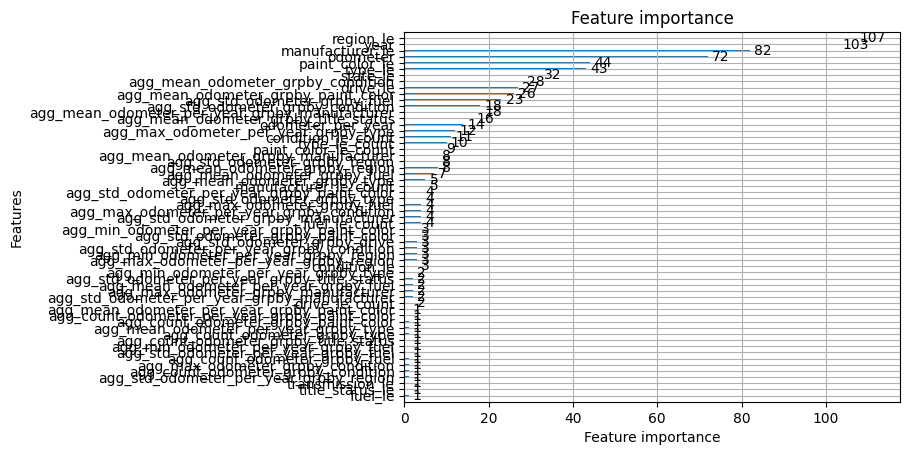

In [27]:
lgb.plot_importance(model)